## Goal: investigate how the rate of virus spread varies geographically based on US county-level data

Basic assumptions:

-Want to fit an exponential curve to the infection growth. The growth rate may vary geographically with different features such as population density, ...

-Because tests are not widely available, the number of infected cases is hard to track. However, death cases are well documented and trackable. Assuming the mortality rate is fixed and same for all counties, death counts are proportional to the number of infected cases and share the same exponential growth coefficient. Thus we use death count data in our analysis.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [389]:
# read in data that includes county-level population density and time-series death counts 
df_density = pd.read_csv("/Users/yujiazhang/Downloads/covid_county_data (1).csv")
df_density.head()

,Unnamed: 0,date,county_name,long_county_name,state,pop_density,population,death_count
0,0,1/22/20,Autauga,"Autauga, Alabama, US",Alabama,91.8,55869,0
1,1,1/22/20,Baldwin,"Baldwin, Alabama, US",Alabama,114.6,223234,0
2,2,1/22/20,Barbour,"Barbour, Alabama, US",Alabama,31.0,24686,0
3,3,1/22/20,Bibb,"Bibb, Alabama, US",Alabama,36.8,22394,0
4,4,1/22/20,Blount,"Blount, Alabama, US",Alabama,88.9,57826,0


In [390]:
# Get county names; 3140 counties in total
# Moreover, we need long county names because some county names appear more than once 
# (e.g. Bibb, Alabama and Bibb, Georgia)

county_names = df_density['county_name'][0:3140]
long_county_names = df_density['long_county_name'][0:3140]

# Create county_reg dataframe for regression
county_reg = pd.DataFrame({'county name' : long_county_names})

# get population density of each county and store in regression df; this will be our covariate
# unit: number of people / square mile

pop_density = df_density['pop_density'][0:3140]
county_reg['pop_density'] = pop_density

county_reg.head()

,county name,pop_density
0,"Autauga, Alabama, US",91.8
1,"Baldwin, Alabama, US",114.6
2,"Barbour, Alabama, US",31.0
3,"Bibb, Alabama, US",36.8
4,"Blount, Alabama, US",88.9


### First: estimate the exponential growth rate before social distancing was widely adopted

In [4]:
# specify a cutoff date, roughly ~ 2 weeks after social distancing measures are enforced
# we only consider data before the cutoff date because those are representative of the 
# infection trends without distancing

cutoffdate_str = '4/5/20'


In [102]:
# now we compute the PRE-social-distancing log(alpha) for each county
# by averaging log(deaths(t+1)/deaths(t)) over the days from 1st death to 4/5

valid = np.zeros(3140)
mean = np.zeros(3140)
sd = np.zeros(3140)

for i in range(len(county_names)):
    
    # for each county, start computing after the occurrence of the first death
    county = df_density[df_density['long_county_name'] == long_county_names[i]]
    
    cutoffdate = np.where(county['date'] == cutoffdate_str)[0][0]
    
    # find the time of the first death
    if any(county['death_count']>=1):
        first_death_time = np.min(np.where(county['death_count']>=1))
    
        if first_death_time >= cutoffdate:
            # if the first death of the county occurred after the last day of interest
            # we do not include this county in the regression
        
            valid[i] = False
        
        else:
            # if the first death occurred before the last day of interest
            # include it in the regression, and estimate difference-in-log(deaths) value
            valid[i] = True
            
            valid_death_counts = county['death_count'][first_death_time : (cutoffdate+1)]
            difflog = []
            for j in range(1, len(valid_death_counts)):
                difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))
            
            #difflog = diff_log(valid_death_counts)
            
            x = np.ones(len(difflog))
            mod = sm.OLS(difflog, x, missing='drop')
            res = mod.fit()
            
            mean[i] = res.params[0]
            sd[i] = res.bse[0]
            
    else:
        valid[i] = False

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [392]:
county_reg['mean_PRE'] = mean
county_reg['sd_PRE'] = sd

county_reg_valid = county_reg[valid==1]

In [393]:
county_reg.head()

,county name,pop_density,mean_PRE,sd_PRE
0,"Autauga, Alabama, US",91.8,0.0,0.0
1,"Baldwin, Alabama, US",114.6,0.0,0.0
2,"Barbour, Alabama, US",31.0,0.0,0.0
3,"Bibb, Alabama, US",36.8,0.0,0.0
4,"Blount, Alabama, US",88.9,0.0,0.0


In [394]:
county_reg.to_csv('/Users/yujiazhang/Downloads/county_logalpha.csv')

Text(0.5, 1.0, 'County-wise log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

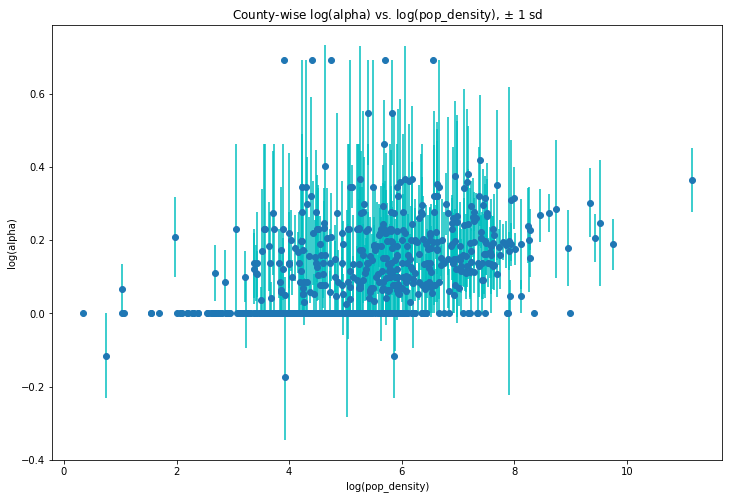

In [454]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_valid['pop_density']
y = county_reg_valid['mean_PRE']
yerr = county_reg_valid['sd_PRE']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("County-wise log(alpha) vs. log(pop_density), $\pm$ 1 sd")

### Next: weighted linear regression

The next step is to do a weighted linear regression, with weights inversely proportional to variance. As we can see from the graph above, many data points don't have an error bar around them - this corresponds to zero variance and will result in a weight of infinity. 

As a first try, we simply drop the points with zero variance. This is not unreasonable because these points are counties with very few deaths that didn't grow over time in our examined time window (usually 1 case throughout) or counties with only 1 or 2 observations (days) from the first death to 4/5. Either way, they are not very informative of the virus's spreading behavior, so we drop them for now.

In [455]:
# Try: drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0 = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0)

340

In [456]:
# WLS on remaining 381 terms

X_wls_0 = np.log(np.delete(x.values, drop0))
y_wls_0 = np.delete(y.values, drop0)
yerr_wls_0 = np.delete(yerr.values, drop0)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            WLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1228.
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          4.27e-121
Time:                        23:06:10   Log-Likelihood:                 366.26
No. Observations:                 381   AIC:                            -730.5
Df Residuals:                     380   BIC:                            -726.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0211      0.001     35.044      0.0

Text(0.5, 1.0, 'PRE-social-distancing log(alpha) vs log(pop_density)')

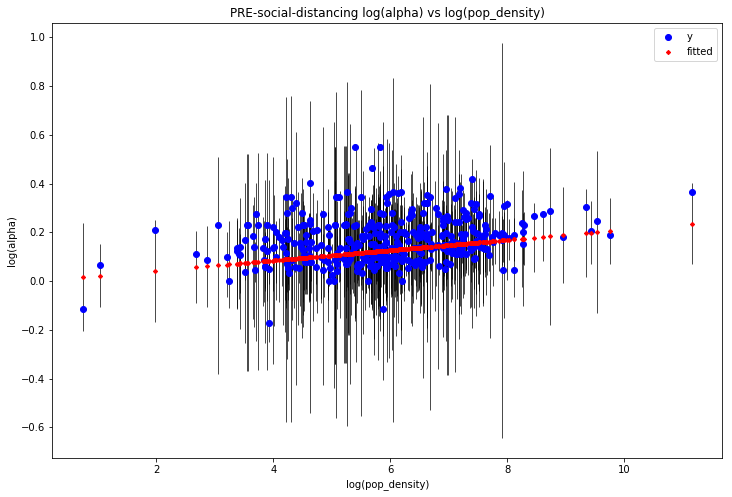

In [457]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("PRE-social-distancing log(alpha) vs log(pop_density)")


In [ ]:
# the next thing to try: smooth out the death counts over a window when running 
# individual regressions for counties
# perhaps this will eliminate the 0-variance issues


# or: filter by death counts?

### Furthermore: we are interested in estimating the growth rate after social distancing measures were widely adopted
say, after 4/5/2020

In [424]:
# run the same regression for POST-social-distancing log(alpha)
# by averaging log(deaths(t+1)/deaths(t)) over the days after 4/5

valid_POST = np.zeros(3140)
mean_POST = np.zeros(3140)
sd_POST = np.zeros(3140)

for i in range(len(county_names)):
    
    county = df_density[df_density['long_county_name'] == long_county_names[i]] 
    cutoffdate = np.where(county['date'] == cutoffdate_str)[0][0]
    
    # if there is a death, compute mean starting from max(4/5, first death)
    # else, set valid_POST to false
    
    if any(county['death_count'] >= 1):
        
        valid_POST[i] = True
        
        first_death_time = np.min(np.where(county['death_count']>=1))
        start = np.max([first_death_time, cutoffdate])
        valid_death_counts = county['death_count'][start:]
        
        if len(valid_death_counts)==1:
            mean_POST[i] = 0
            sd_POST[i] = 0     
        else:
            # to rule out nonmonotonic death counts (data error)
            if any(valid_death_counts==0):
                valid_POST[i] = False
            else:
                difflog = []
                for j in range(1, len(valid_death_counts)):
                    difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))

                x = np.ones(len(difflog))
                mod = sm.OLS(difflog, x, missing='drop')
                res = mod.fit()

                mean_POST[i] = res.params[0]
                sd_POST[i] = res.bse[0]
        
        
    else:
        valid_POST[i] = False
    

Autauga
235500    1
238640    1
241780    1
244920    1
248060    1
251200    1
254340    1
Name: death_count, dtype: int64
Baldwin
229221    1
232361    1
235501    1
238641    1
241781    1
244921    1
248061    1
251201    1
254341    1
Name: death_count, dtype: int64
Barbour
Bibb
Blount
Bullock
Butler
Calhoun
Chambers
229228    6
232368    7
235508    8
238648    8
241788    8
244928    8
248068    8
251208    8
254348    8
Name: death_count, dtype: int64
Cherokee
Chilton
Choctaw
Clarke
Clay
Cleburne
Coffee
Colbert
235516    1
238656    1
241796    1
244936    1
248076    1
251216    1
254356    1
Name: death_count, dtype: int64
Conecuh
Coosa
Covington
Crenshaw
Cullman
229241    1
232381    1
235521    1
238661    1
241801    1
244941    1
248081    1
251221    1
254361    1
Name: death_count, dtype: int64
Dale
Dallas
DeKalb
Elmore
Escambia
Etowah
229247    3
232387    3
235527    4
238667    4
241807    4
244947    5
248087    6
251227    7
254367    7
Name: death_count, dtype: in

232568    1
235708    1
238848    3
241988    3
245128    3
248268    3
251408    3
254548    3
Name: death_count, dtype: int64
Modoc
Mono
229430    1
232570    1
235710    1
238850    1
241990    1
245130    1
248270    1
251410    1
254550    1
Name: death_count, dtype: int64
Monterey
229431    2
232571    2
235711    2
238851    2
241991    2
245131    3
248271    3
251411    3
254551    3
Name: death_count, dtype: int64
Napa
229432    2
232572    2
235712    2
238852    2
241992    2
245132    2
248272    2
251412    2
254552    2
Name: death_count, dtype: int64
Nevada
229433    1
232573    1
235713    1
238853    1
241993    1
245133    1
248273    1
251413    1
254553    1
Name: death_count, dtype: int64
Orange
229434    14
232574    14
235714    15
238854    17
241994    17
245134    17
248274    18
251414    19
254554    19
Name: death_count, dtype: int64
Placer
229435    3
232575    3
235715    3
238855    4
241995    4
245135    4
248275    4
251415    4
254555    5
Name: dea

229533    11
232673    13
235813    13
238953    13
242093    13
245233    14
248373    15
251513    17
254653    17
Name: death_count, dtype: int64
Windham
229534    1
232674    1
235814    1
238954    1
242094    1
245234    1
248374    1
251514    1
254654    1
Name: death_count, dtype: int64
Kent
229535    2
232675    3
235815    4
238955    4
242095    4
245235    4
248375    4
251515    4
254655    6
Name: death_count, dtype: int64
New Castle
229536     7
232676     9
235816     9
238956     9
242096     9
245236     9
248376    19
251516    19
254656    20
Name: death_count, dtype: int64
Sussex
229537     3
232677     3
235817     3
238957     3
242097     3
245237     3
248377    10
251517    10
254657    15
Name: death_count, dtype: int64
District of Columbia
229538    22
232678    24
235818    22
238958    27
242098    32
245238    38
248378    47
251518    50
254658    52
Name: death_count, dtype: int64
Alachua
Baker
238960    1
242100    2
245240    2
248380    2
251520    

Candler
Carroll
229627    2
232767    2
235907    4
239047    4
242187    4
245327    5
248467    5
251607    5
254747    5
Name: death_count, dtype: int64
Catoosa
Charlton
Chatham
229630    3
232770    3
235910    4
239050    4
242190    4
245330    5
248470    5
251610    5
254750    5
Name: death_count, dtype: int64
Chattahoochee
Chattooga
235912    1
239052    1
242192    1
245332    1
248472    1
251612    1
254752    1
Name: death_count, dtype: int64
Cherokee
229633    5
232773    5
235913    5
239053    6
242193    6
245333    7
248473    7
251613    7
254753    7
Name: death_count, dtype: int64
Clarke
229634     8
232774     8
235914     9
239054     9
242194     9
245334    10
248474    11
251614    11
254754    11
Name: death_count, dtype: int64
Clay
235915    1
239055    1
242195    1
245335    1
248475    1
251615    1
254755    1
Name: death_count, dtype: int64
Clayton
229636     9
232776     9
235916    10
239056    11
242196    11
245336    11
248476    11
251616    11
2

239155    1
242295    1
245435    1
248575    1
251715    1
254855    1
Name: death_count, dtype: int64
Taliaferro
Tattnall
Taylor
232878    1
236018    1
239158    2
242298    2
245438    2
248578    2
251718    2
254858    2
Name: death_count, dtype: int64
Telfair
Terrell
229740     2
232880     3
236020     9
239160     9
242300     9
245440    10
248580    10
251720    10
254860    10
Name: death_count, dtype: int64
Thomas
239161    2
242301    2
245441    3
248581    3
251721    3
254861    3
Name: death_count, dtype: int64
Tift
236022    1
239162    1
242302    1
245442    1
248582    1
251722    1
254862    2
Name: death_count, dtype: int64
Toombs
229743    1
232883    1
236023    1
239163    1
242303    1
245443    1
248583    1
251723    1
254863    1
Name: death_count, dtype: int64
Towns
Treutlen
Troup
229746    1
232886    1
236026    3
239166    3
242306    3
245446    3
248586    3
251726    3
254866    3
Name: death_count, dtype: int64
Turner
Twiggs
Union
242309    1
2454

Clinton
242487    1
245627    1
248767    1
251907    1
255047    1
Name: death_count, dtype: int64
Crawford
Daviess
239349    1
242489    1
245629    1
248769    1
251909    1
255049    1
Name: death_count, dtype: int64
Dearborn
229930    1
233070    1
236210    1
239350    2
242490    2
245630    3
248770    3
251910    3
255050    3
Name: death_count, dtype: int64
Decatur
229931     4
233071     4
236211     6
239351     6
242491     6
245631     8
248771    10
251911    10
255051    10
Name: death_count, dtype: int64
DeKalb
Delaware
229933    1
233073    1
236213    1
239353    1
242493    1
245633    1
248773    2
251913    2
255053    2
Name: death_count, dtype: int64
Dubois
Elkhart
229935    3
233075    3
236215    3
239355    3
242495    3
245635    3
248775    3
251915    3
255055    3
Name: death_count, dtype: int64
Fayette
229936    3
233076    3
236216    3
239356    3
242496    3
245636    3
248776    3
251916    3
255056    3
Name: death_count, dtype: int64
Floyd
236217  

Lucas
Lyon
Madison
255188    1
Name: death_count, dtype: int64
Mahaska
Marion
Marshall
Mills
Mitchell
Monona
Monroe
Montgomery
Muscatine
230077    1
233217    1
236357    1
239497    1
242637    1
245777    1
248917    1
252057    1
255197    1
Name: death_count, dtype: int64
O'Brien
Osceola
Page
Palo Alto
Plymouth
Pocahontas
Polk
230084    2
233224    4
236364    4
239504    4
242644    4
245784    4
248924    4
252064    4
255204    4
Name: death_count, dtype: int64
Pottawattamie
Poweshiek
230086    1
233226    1
236366    1
239506    1
242646    1
245786    1
248926    1
252066    1
255206    1
Name: death_count, dtype: int64
Ringgold
Sac
Scott
230089    1
233229    1
236369    1
239509    1
242649    1
245789    1
248929    1
252069    1
255209    1
Name: death_count, dtype: int64
Shelby
Sioux
Story
Tama
233233    2
236373    2
239513    2
242653    2
245793    2
248933    2
252073    2
255213    2
Name: death_count, dtype: int64
Taylor
Union
Van Buren
Wapello
Warren
Washington
230

230348    22
233488    25
236628    31
239768    33
242908    36
246048    39
249188    45
252328    49
255468    52
Name: death_count, dtype: int64
East Carroll
East Feliciana
239770    1
242910    2
246050    2
249190    2
252330    2
255470    2
Name: death_count, dtype: int64
Evangeline
Franklin
246052    1
249192    1
252332    1
255472    1
Name: death_count, dtype: int64
Grant
Iberia
230354    3
233494    5
236634    5
239774    4
242914    5
246054    5
249194    5
252334    5
255474    5
Name: death_count, dtype: int64
Iberville
230355     5
233495     6
236635     8
239775     9
242915     9
246055    10
249195    12
252335    14
255475    16
Name: death_count, dtype: int64
Jackson
Jefferson
230357    113
233497    121
236637    137
239777    149
242917    158
246057    165
249197    166
252337    173
255477    186
Name: death_count, dtype: int64
Jefferson Davis
233498    1
236638    1
239778    1
242918    2
246058    2
249198    7
252338    3
255478    3
Name: death_count, 

230448    27
233588    31
236728    40
239868    48
243008    48
246148    48
249288    79
252428    86
255568    86
Name: death_count, dtype: int64
Worcester
230449    17
233589    18
236729    23
239869    29
243009    29
246149    29
249289    41
252429    49
255569    49
Name: death_count, dtype: int64
Alcona
Alger
Allegan
Alpena
Antrim
Arenac
Baraga
Barry
Bay
252438    2
255578    2
Name: death_count, dtype: int64
Benzie
Berrien
230460    1
233600    1
236740    2
239880    2
243020    2
246160    2
249300    3
252440    4
255580    4
Name: death_count, dtype: int64
Branch
230461    1
233601    1
236741    1
239881    1
243021    1
246161    2
249301    2
252441    2
255581    2
Name: death_count, dtype: int64
Calhoun
230462    1
233602    1
236742    1
239882    1
243022    1
246162    1
249302    1
252442    1
255582    2
Name: death_count, dtype: int64
Cass
230463    1
233603    1
236743    1
239883    1
243023    1
246163    1
249303    1
252443    1
255583    1
Name: death_co

Kandiyohi
Kittson
Koochiching
Lac qui Parle
Lake
Lake of the Woods
Le Sueur
Lincoln
Lyon
McLeod
Mahnomen
Marshall
Martin
230578    3
233718    4
236858    4
239998    4
243138    4
246278    4
249418    4
252558    4
255698    4
Name: death_count, dtype: int64
Meeker
Mille Lacs
Morrison
Mower
Murray
Nicollet
249424    1
252564    1
255704    1
Name: death_count, dtype: int64
Nobles
Norman
Olmsted
230587    3
233727    2
236867    2
240007    2
243147    2
246287    2
249427    2
252567    2
255707    2
Name: death_count, dtype: int64
Otter Tail
Pennington
Pine
Pipestone
Polk
Pope
Ramsey
230594    2
233734    3
236874    3
240014    3
243154    5
246294    5
249434    6
252574    6
255714    6
Name: death_count, dtype: int64
Red Lake
Redwood
Renville
Rice
Rock
Roseau
St. Louis
243161    1
246301    4
249441    4
252581    5
255721    5
Name: death_count, dtype: int64
Scott
230602    1
233742    1
236882    1
240022    1
243162    1
246302    1
249442    1
252582    1
255722    1
Name: d

Christian
Clark
Clay
237005    1
240145    1
243285    1
246425    1
249565    1
252705    2
255845    2
Name: death_count, dtype: int64
Clinton
Cole
230727    1
233867    1
237007    1
240147    1
243287    1
246427    1
249567    1
252707    1
255847    1
Name: death_count, dtype: int64
Cooper
Crawford
Dade
Dallas
Daviess
DeKalb
Dent
Douglas
Dunklin
Franklin
233877    3
237017    3
240157    3
243297    3
246437    3
249577    3
252717    3
255857    3
Name: death_count, dtype: int64
Gasconade
Gentry
Greene
230740    7
233880    7
237020    7
240160    7
243300    7
246440    8
249580    8
252720    8
255860    8
Name: death_count, dtype: int64
Grundy
Harrison
Henry
230743    1
233883    1
237023    1
240163    1
243303    1
246443    1
249583    1
252723    1
255863    1
Name: death_count, dtype: int64
Hickory
Holt
Howard
Howell
Iron
Jackson
230749    3
233889    4
237029    4
240169    4
243309    5
246449    5
249589    7
252729    7
255869    7
Name: death_count, dtype: int64
Jas

231006     55
234146     60
237286     87
240426    102
243567    117
246706    135
249846    152
252986    162
256126    162
Name: death_count, dtype: int64
Ocean
231007     62
234147     71
237287     85
240427    101
243568    119
246707    121
249847    132
252987    138
256127    141
Name: death_count, dtype: int64
Passaic
231008     42
234148     53
237288     62
240428     71
243569     82
246708    101
249848    119
252988    131
256128    136
Name: death_count, dtype: int64
Salem
231009    2
234149    2
237289    3
240429    3
243570    3
246709    3
249849    3
252989    4
256129    4
Name: death_count, dtype: int64
Somerset
231010    26
234150    31
237290    40
240430    46
243571    59
246710    69
249850    78
252990    79
256130    85
Name: death_count, dtype: int64
Sussex
231011     9
234151    11
237291    15
240431    21
243572    21
246711    26
249851    27
252991    35
256131    38
Name: death_count, dtype: int64
Union
231012     71
234152     78
237292     95
2404

231124    0
234264    1
237404    1
240544    1
243684    1
246824    1
249964    1
253104    1
256244    1
Name: death_count, dtype: int64
Caswell
Catawba
231126    1
234266    1
237406    1
240546    1
243686    1
246826    1
249966    1
253106    1
256246    1
Name: death_count, dtype: int64
Chatham
Cherokee
231128    1
234268    1
237408    1
240548    1
243688    1
246828    1
249968    1
253108    1
256248    1
Name: death_count, dtype: int64
Chowan
Clay
Cleveland
Columbus
237412    1
240552    1
243692    1
246832    1
249972    1
253112    1
256252    1
Name: death_count, dtype: int64
Craven
243693    1
246833    1
249973    1
253113    1
256253    1
Name: death_count, dtype: int64
Cumberland
240554    1
243694    1
246834    1
249974    1
253114    1
256254    1
Name: death_count, dtype: int64
Currituck
Dare
243696    1
246836    1
249976    1
253116    1
256256    1
Name: death_count, dtype: int64
Davidson
234277    1
237417    1
240557    1
243697    2
246837    2
249977    

256404    1
Name: death_count, dtype: int64
Fayette
Franklin
231286     8
234426     9
237566    12
240706    12
243846    14
246986    14
250126    14
253266    14
256406    15
Name: death_count, dtype: int64
Fulton
Gallia
231288    1
234428    1
237568    1
240708    1
243848    1
246988    1
250128    1
253268    1
256408    1
Name: death_count, dtype: int64
Geauga
240709    1
243849    1
246989    1
250129    2
253269    2
256409    2
Name: death_count, dtype: int64
Greene
231290    1
234430    1
237570    1
240710    1
243850    1
246990    1
250130    1
253270    1
256410    1
Name: death_count, dtype: int64
Guernsey
Hamilton
231292     3
234432     9
237572    12
240712    13
243852    14
246992    14
250132    17
253272    17
256412    21
Name: death_count, dtype: int64
Hancock
250133    1
253273    1
256413    1
Name: death_count, dtype: int64
Hardin
Harrison
Henry
Highland
Hocking
Holmes
Huron
231300    1
234440    1
237580    1
240720    1
243860    1
247000    1
250140    1

Columbia
Coos
Crook
Curry
Deschutes
Douglas
Gilliam
Grant
Harney
Hood River
Jackson
Jefferson
Josephine
253423    1
256563    1
Name: death_count, dtype: int64
Klamath
Lake
Lane
231446    1
234586    1
237726    1
240866    1
244006    1
247146    1
250286    1
253426    1
256566    1
Name: death_count, dtype: int64
Lincoln
Linn
231448    2
234588    2
237728    2
240868    2
244008    4
247148    4
250288    4
253428    4
256568    4
Name: death_count, dtype: int64
Malheur
Marion
231450    5
234590    5
237730    6
240870    9
244010    9
247150    9
250290    9
253430    9
256570    9
Name: death_count, dtype: int64
Morrow
Multnomah
231452     7
234592     7
237732     7
240872     7
244012    13
247152    13
250292    17
253432    19
256572    19
Name: death_count, dtype: int64
Polk
231453    1
234593    1
237733    1
240873    1
244013    1
247153    1
250293    1
253433    1
256573    1
Name: death_count, dtype: int64
Sherman
Tillamook
Umatilla
Union
Wallowa
Wasco
Washington
23146

231566    3
234706    3
237846    5
240986    5
244126    6
247266    6
250406    6
253546    6
256686    6
Name: death_count, dtype: int64
McCormick
244127    1
247267    1
250407    1
253547    1
256687    1
Name: death_count, dtype: int64
Marion
231568    1
234708    1
237848    1
240988    1
244128    1
247268    1
250408    1
253548    1
256688    1
Name: death_count, dtype: int64
Marlboro
Newberry
244130    1
247270    1
250410    1
253550    1
256690    1
Name: death_count, dtype: int64
Oconee
Orangeburg
Pickens
Richland
231574     6
234714     7
237854     7
240994     7
244134    10
247274    10
250414    10
253554    10
256694    10
Name: death_count, dtype: int64
Saluda
Spartanburg
234716    1
237856    1
240996    1
244136    4
247276    4
250416    4
253556    4
256696    4
Name: death_count, dtype: int64
Sumter
231577    3
234717    3
237857    3
240997    3
244137    3
247277    3
250417    4
253557    4
256697    4
Name: death_count, dtype: int64
Union
Williamsburg
York

Fannin
Fayette
Fisher
Floyd
Foard
Fort Bend
231819     5
234959     6
238099     6
241239     6
244379     7
247519    10
250659    11
253799    11
256939    11
Name: death_count, dtype: int64
Franklin
Freestone
Frio
Gaines
256943    1
Name: death_count, dtype: int64
Galveston
231824    1
234964    1
238104    1
241244    5
244384    5
247524    7
250664    8
253804    8
256944    8
Name: death_count, dtype: int64
Garza
Gillespie
Glasscock
Goliad
Gonzales
Gray
Grayson
Gregg
Grimes
Guadalupe
Hale
244395    1
247535    1
250675    2
253815    2
256955    5
Name: death_count, dtype: int64
Hall
Hamilton
Hansford
Hardeman
Hardin
231840    1
234980    1
238120    1
241260    1
244400    1
247540    1
250680    2
253820    2
256960    2
Name: death_count, dtype: int64
Harris
231841    20
234981    22
238121    23
241261    31
244401    34
247541    40
250681    41
253821    44
256961    46
Name: death_count, dtype: int64
Harrison
231842    1
234982    1
238122    1
241262    1
244402    1
247

Amherst
Appomattox
Arlington
232044    2
235184    2
238324    2
241464    2
244604    2
247744    2
250884    2
254024    2
257164    2
Name: death_count, dtype: int64
Augusta
Bath
Bedford
Bland
Botetourt
Brunswick
Buchanan
Buckingham
Campbell
Caroline
Carroll
Charles City
Charlotte
Chesterfield
Clarke
Craig
Culpeper
Cumberland
Dickenson
Dinwiddie
Essex
Fairfax
232066     2
235206     2
238346     2
241486     9
244626    16
247766    19
250906    20
254046    20
257186    20
Name: death_count, dtype: int64
Fauquier
Floyd
Fluvanna
Franklin
Frederick
Giles
Gloucester
Goochland
Grayson
Greene
Greensville
Halifax
Hanover
Henrico
232080     2
235220     2
238360     2
241500     2
244640     2
247780     2
250920     2
254060    42
257200    42
Name: death_count, dtype: int64
Henry
Highland
Isle of Wight
James City
232084    2
235224    2
238364    2
241504    2
244644    2
247784    2
250924    2
254064    2
257204    2
Name: death_count, dtype: int64
King and Queen
King George
King Will

Manitowoc
Marathon
254281    1
257421    1
Name: death_count, dtype: int64
Marinette
Marquette
Menominee
Milwaukee
232305    39
235445    40
238585    49
241725    56
244865    65
248005    77
251145    85
254285    88
257425    94
Name: death_count, dtype: int64
Monroe
Oconto
Oneida
Outagamie
232309    1
235449    1
238589    1
241729    1
244869    2
248009    2
251149    2
254289    2
257429    2
Name: death_count, dtype: int64
Ozaukee
232310    6
235450    6
238590    7
241730    7
244870    8
248010    9
251150    9
254290    9
257430    9
Name: death_count, dtype: int64
Pepin
Pierce
Polk
Portage
Price
Racine
232316    1
235456    2
238596    2
241736    2
244876    2
248016    3
251156    3
254296    3
257436    4
Name: death_count, dtype: int64
Richland
Rock
232318    2
235458    2
238598    2
241738    2
244878    2
248018    2
251158    3
254298    4
257438    3
Name: death_count, dtype: int64
Rusk
St. Croix
Sauk
232321    2
235461    2
238601    2
241741    2
244881    2
2480

In [428]:
# store in county_reg dataframe and extract valid rows
county_reg['mean_POST'] = mean_POST
county_reg['sd_POST'] = sd_POST

county_reg_POST_valid = county_reg[valid_POST==1]

In [429]:
county_reg_POST_valid.shape

(1014, 6)

Text(0.5, 1.0, 'County-wise post-soc-distancing log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

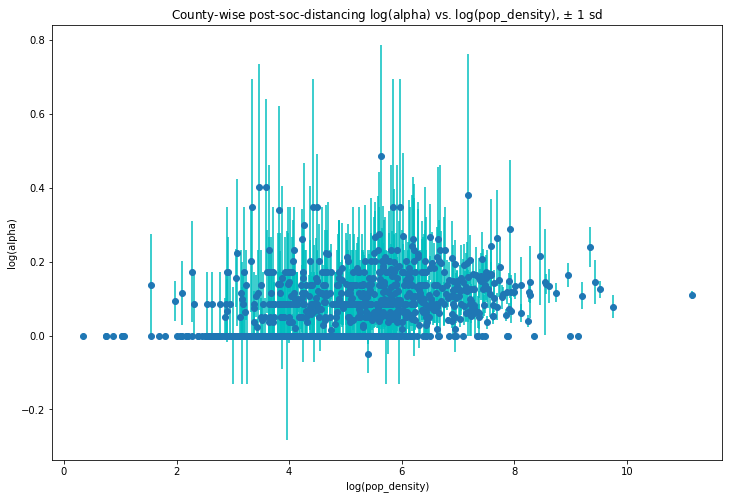

In [458]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_POST_valid['pop_density']
y = county_reg_POST_valid['mean_POST']
yerr = county_reg_POST_valid['sd_POST']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("County-wise post-soc-distancing log(alpha) vs. log(pop_density), $\pm$ 1 sd")

In [459]:
# Drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0_POST = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0_POST)

429

In [460]:
# WLS on remaining 585 terms

X_wls_0 = np.log(np.delete(x.values, drop0_POST))
y_wls_0 = np.delete(y.values, drop0_POST)
yerr_wls_0 = np.delete(yerr.values, drop0_POST)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.769
Model:                            WLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     1939.
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          1.04e-187
Time:                        23:06:41   Log-Likelihood:                 742.15
No. Observations:                 585   AIC:                            -1482.
Df Residuals:                     584   BIC:                            -1478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0124      0.000     44.032      0.0

Text(0.5, 1.0, 'POST-social-distancing log(alpha) vs log(pop_density)')

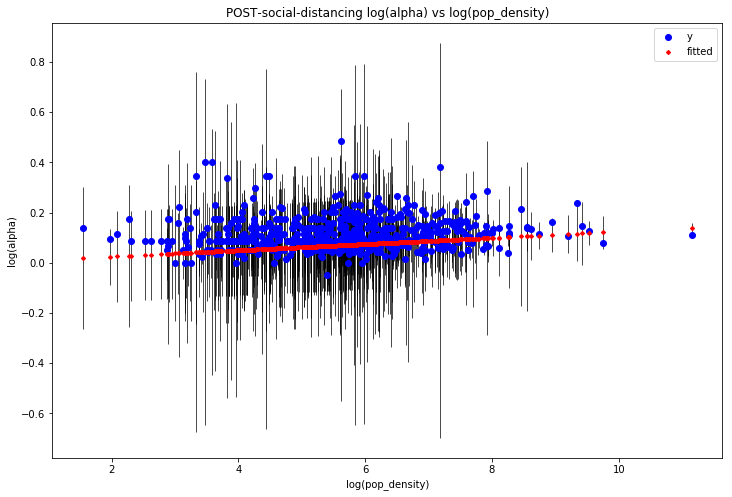

In [461]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("POST-social-distancing log(alpha) vs log(pop_density)")

### Illustration: How are the county-level population densities distributed in terms of the severity of the virus?

Text(0, 0.5, 'Number of instances')

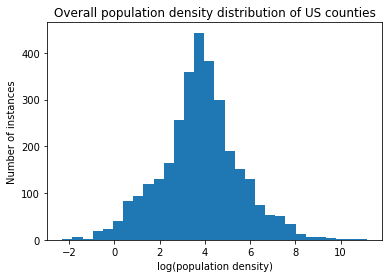

In [362]:
# overall population density distribution
# peak around 4

plt.hist(np.log(pop_density+0.1), bins=30)
plt.title('Overall population density distribution of US counties')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

Text(0, 0.5, 'Number of instances')

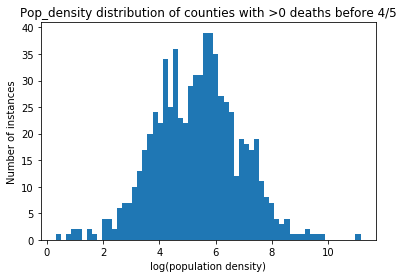

In [371]:
# distribution of pop_density of counties with >0 deaths before 4/5
# we can see it is almost bimodal with a larger peak shifting towards 6

plt.hist(np.log(pop_density[np.where(valid==1)[0]]),bins=60)
plt.title('Pop_density distribution of counties with >0 deaths before 4/5')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of instances')

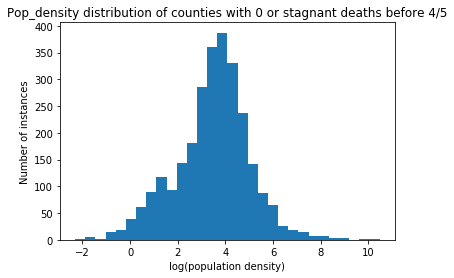

In [372]:
# population density distribution for "stagnant" counties with no or ungrowing deaths
# the distribution is still centered around 4, similar to overall US shape

stagnant = np.where(mean <= 0)[0]

plt.hist(np.log(pop_density[stagnant]+0.1), bins=30)
plt.title('Pop_density distribution of counties with 0 or stagnant deaths before 4/5')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

Text(0, 0.5, 'Number of instances')

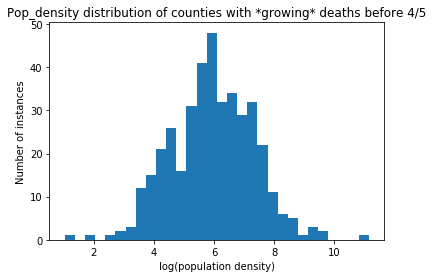

In [361]:
# For counties whose death counts are growing (log(alpha)>0):
# their log densities are concentrated around 6, much higher than the US average

plt.hist(np.log(np.delete(pop_density.values, stagnant)), bins=30)
plt.title('Pop_density distribution of counties with *growing* deaths before 4/5')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')